# Spray-Train Cleaning and Map Visualisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import ensemble, preprocessing

In [33]:
# Load dataset 
train = pd.read_csv('../datasets/processed/train_cleaned_eda.csv')
#test = pd.read_csv('test.csv')
#sample = pd.read_csv('sampleSubmission.csv')
#weather = pd.read_csv('weather.csv')
spray = pd.read_csv('../datasets/source/spray.csv')

In [11]:
mapdata = np.loadtxt("../datasets/mapdata_copyright_openstreetmap_contributors.txt")

In [ ]:
origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

## Spray data

In [4]:
print(spray.shape)
spray.head()

(14835, 4)


Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [13]:
spray.columns = spray.columns.str.lower()

In [14]:
spray['date'] = pd.to_datetime(spray['date'])
spray.set_index('date', inplace=True)
spray.sort_index(inplace=True)

In [15]:
spray.head()

time   latitude  longitude
date                                        
2011-08-29  6:56:58 PM  42.391623 -88.089163
2011-08-29  6:57:08 PM  42.391348 -88.089163
2011-08-29  6:57:18 PM  42.391022 -88.089157
2011-08-29  6:57:28 PM  42.390637 -88.089158
2011-08-29  6:57:38 PM  42.390410 -88.088858

In [16]:
spray[spray.duplicated(keep=False)]

time   latitude  longitude
date                                        
2011-09-07  7:43:40 PM  41.983917 -87.793088
2011-09-07  7:43:40 PM  41.983917 -87.793088
2011-09-07  7:44:32 PM  41.986460 -87.794225
2011-09-07  7:44:32 PM  41.986460 -87.794225
2011-09-07  7:44:32 PM  41.986460 -87.794225
...                ...        ...        ...
2011-09-07  7:44:32 PM  41.986460 -87.794225
2011-09-07  7:44:32 PM  41.986460 -87.794225
2011-09-07  7:44:32 PM  41.986460 -87.794225
2011-09-07  7:44:32 PM  41.986460 -87.794225
2011-09-07  7:44:32 PM  41.986460 -87.794225

[543 rows x 3 columns]

In [17]:
# Drop spray duplicates
spray.drop_duplicates(keep='first',inplace=True)

In [21]:
spray.isnull().sum()

time         584
latitude       0
longitude      0
year           0
dtype: int64

In [24]:
spray[spray['time'].isnull()].head()

time   latitude  longitude  year
date                                       
2011-09-07  NaN  41.987092 -87.794286  2011
2011-09-07  NaN  41.987620 -87.794382  2011
2011-09-07  NaN  41.988004 -87.794574  2011
2011-09-07  NaN  41.988292 -87.795486  2011
2011-09-07  NaN  41.988100 -87.796014  2011

In [25]:
# Time is not really important anyway so let's drop it
spray.drop(columns='time', inplace=True)

In [35]:
spray['year'] = spray.index.year
spray['month'] = spray.index.month
spray['week'] = spray.index.isocalendar().week

In [38]:
print(spray['year'].unique())
print(spray['month'].unique())
print(spray['week'].unique())

[2011 2013]
[8 9 7]
<IntegerArray>
[35, 36, 29, 30, 32, 33, 34]
Length: 7, dtype: UInt32


In [29]:
spray.groupby(['year','month','week'])['latitude'].count()

year  month
2011  8          95
      9        1573
2013  7        3809
      8        7893
      9         924
Name: latitude, dtype: int64

#### Dropping spray data beyond the borders of the map

In [30]:
spray['latitude'].sort_values(ascending=True)

date
2013-08-22    41.713925
2013-08-22    41.714005
2013-08-22    41.714042
2013-07-17    41.714098
2013-07-17    41.714112
                ...    
2011-08-29    42.395095
2011-08-29    42.395218
2011-08-29    42.395352
2011-08-29    42.395697
2011-08-29    42.395983
Name: latitude, Length: 14294, dtype: float64

In [11]:
#spray.drop(spray[spray['Latitude']<41.6].index,inplace=True)

In [31]:
spray['longitude'].sort_values(ascending=True)

date
2011-08-29   -88.096468
2011-08-29   -88.096447
2011-08-29   -88.096445
2011-08-29   -88.096443
2011-08-29   -88.096440
                ...    
2013-08-22   -87.586792
2013-08-22   -87.586787
2013-08-22   -87.586775
2013-08-22   -87.586755
2013-08-22   -87.586727
Name: longitude, Length: 14294, dtype: float64

In [13]:
#spray.drop(spray[spray['Longitude']<-88.0].index,inplace=True)

## Train data

In [34]:
print(train.shape)
train.head()

(8475, 155)


date                 species  trap   latitude  longitude  \
0  2007-05-29           CULEX PIPIENS  T096  41.731922 -87.677512   
1  2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
2  2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
3  2007-05-29  CULEX PIPIENS/RESTUANS  T048  41.867108 -87.654224   
4  2007-05-29  CULEX PIPIENS/RESTUANS  T050  41.919343 -87.694259   

   nummosquitos  wnvpresent   timestamp  year  month  ...  t230  t231 t232  \
0             1           0  2007-05-29  2007      5  ...     0     0    0   
1             1           0  2007-05-29  2007      5  ...     0     0    0   
2             1           0  2007-05-29  2007      5  ...     0     0    0   
3             1           0  2007-05-29  2007      5  ...     0     0    0   
4             1           0  2007-05-29  2007      5  ...     0     0    0   

   t233 t235  t236  t237  t238  t900  t903  
0     0    0     0     0     0     0     0  
1     0    0     0     0     0     0     0  
2     0    0     0     0     0     0     0  
3     0    0     0     0     0     0     0  
4     0    0     0     0     0     0     0  

[5 rows x 155 columns]

In [15]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train.set_index('timestamp', inplace=True)
train.sort_index(inplace=True)

In [16]:
train.head()

Address  \
Date                                                            
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                           Species  Block           Street  Trap  \
Date                                                               
2007-05-29  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
2007-05-29          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2007-05-29          CULEX RESTUANS     62    N MANDELL AVE  T007   
2007-05-29  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
2007-05-29          CULEX RESTUANS     79     W FOSTER AVE  T015   

                       AddressNumberAndStreet   Latitude  Longitude  \
Date                                                                  
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2007-05-29   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   
2007-05-29    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
2007-05-29    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   

            AddressAccuracy  NumMosquitos  WnvPresent  
Date                                                   
2007-05-29                9             1           0  
2007-05-29                9             1           0  
2007-05-29                9             1           0  
2007-05-29                8             1           0  
2007-05-29                8             4           0

In [17]:
train.tail()

Address  \
Date                                                            
2013-09-26      5100 West 72nd Street, Chicago, IL 60638, USA   
2013-09-26    5800 North Ridge Avenue, Chicago, IL 60660, USA   
2013-09-26  1700 North Ashland Avenue, Chicago, IL 60622, USA   
2013-09-26   7100 North Harlem Avenue, Chicago, IL 60631, USA   
2013-09-26      4200 West 65th Street, Chicago, IL 60621, USA   

                           Species  Block          Street  Trap  \
Date                                                              
2013-09-26  CULEX PIPIENS/RESTUANS     51       W 72ND ST  T035   
2013-09-26  CULEX PIPIENS/RESTUANS     58     N RIDGE AVE  T231   
2013-09-26  CULEX PIPIENS/RESTUANS     17   N ASHLAND AVE  T232   
2013-09-26  CULEX PIPIENS/RESTUANS     71    N HARLEM AVE  T233   
2013-09-26  CULEX PIPIENS/RESTUANS     42       W 65TH ST  T235   

                      AddressNumberAndStreet   Latitude  Longitude  \
Date                                                                 
2013-09-26      5100  W 72ND ST, Chicago, IL  41.763733 -87.742302   
2013-09-26    5800  N RIDGE AVE, Chicago, IL  41.987280 -87.666066   
2013-09-26  1700  N ASHLAND AVE, Chicago, IL  41.912563 -87.668055   
2013-09-26   7100  N HARLEM AVE, Chicago, IL  42.009876 -87.807277   
2013-09-26      4200  W 65TH ST, Chicago, IL  41.776428 -87.627096   

            AddressAccuracy  NumMosquitos  WnvPresent  
Date                                                   
2013-09-26                8             6           1  
2013-09-26                8             5           0  
2013-09-26                9             1           0  
2013-09-26                9             5           0  
2013-09-26                8             1           0

In [18]:
print(train['2007'].shape)
print(train['2008'].shape)
print(train['2009'].shape)
print(train['2010'].shape)
print(train['2011'].shape)
print(train['2012'].shape)
print(train['2013'].shape)

(3811, 11)
(0, 11)
(2249, 11)
(0, 11)
(2054, 11)
(0, 11)
(2392, 11)


## Spray-train Map (all-years)

In [ ]:
from ipywidgets import interact, IntSlider
%matplotlib inline

In [19]:
train[train['WnvPresent']==0].shape

(9955, 11)

In [20]:
train[train['WnvPresent']==1].shape

(551, 11)

In [21]:
lats_spray = spray.Latitude
longs_spray = spray.Longitude

In [22]:
lats_train_0 = train[train['WnvPresent']==0].Latitude
longs_train_0 = train[train['WnvPresent']==0].Longitude

In [23]:
lats_train_1 = train[train['WnvPresent']==1].Latitude
longs_train_1 = train[train['WnvPresent']==1].Longitude

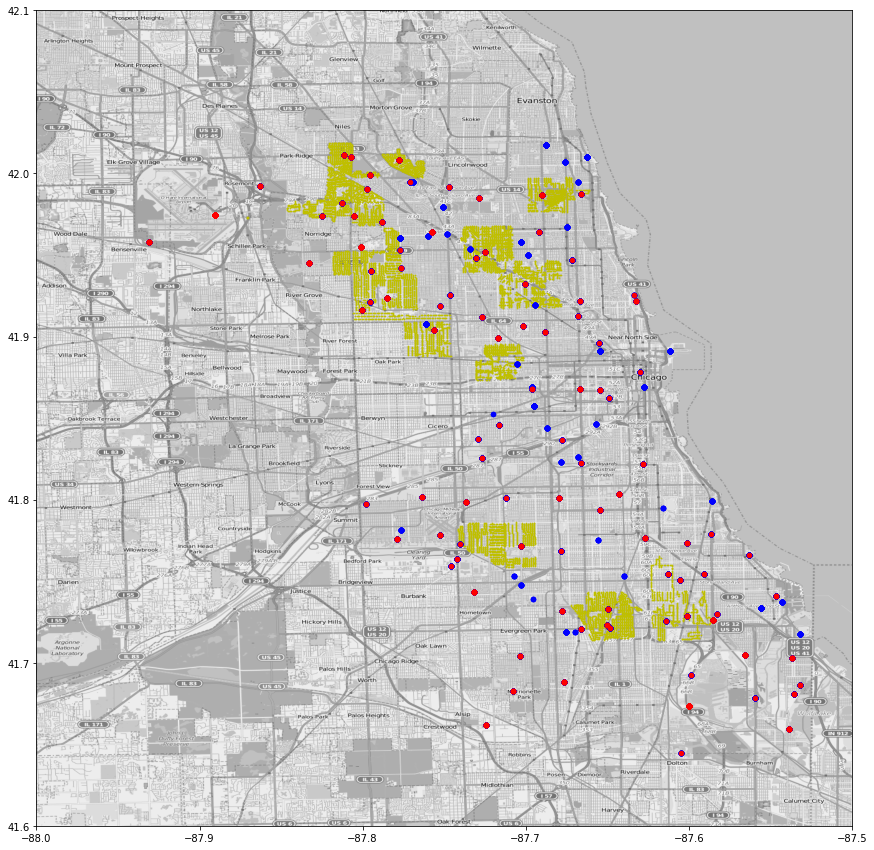

In [24]:
# generate plot
plt.figure(figsize=(20,15))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
plt.scatter(x=longs_spray, y=lats_spray, c='y', s=0.5)
plt.scatter(x=longs_train_0, y=lats_train_0, c='b', s=20)
plt.scatter(x=longs_train_1, y=lats_train_1, c='r', s=20)
#plt.scatter(x=intersection[1], y=intersection[0], c='b', s=60, marker='s')

## Spray-train map 2011

In [25]:
lats_spray_2011 = spray['2011'].Latitude
longs_spray_2011 = spray['2011'].Longitude

In [26]:
train_2011 = train['2011']

In [27]:
lats_train_2011_0 = train_2011[train_2011['WnvPresent']==0].Latitude
longs_train_2011_0 = train_2011[train_2011['WnvPresent']==0].Longitude

In [28]:
lats_train_2011_1 = train_2011[train_2011['WnvPresent']==1].Latitude
longs_train_2011_1 = train_2011[train_2011['WnvPresent']==1].Longitude

In [29]:
#intersection = [41.909614, -87.746134]

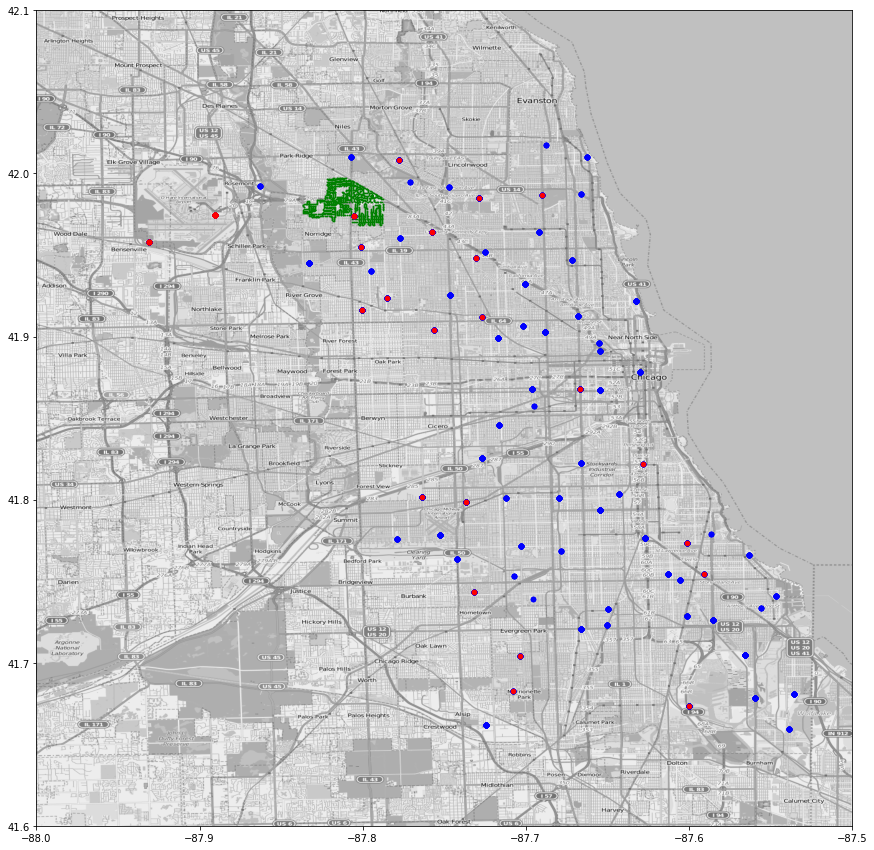

In [30]:
# generate plot
plt.figure(figsize=(20,15))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
plt.scatter(x=longs_spray_2011, y=lats_spray_2011, c='g', s=0.5)
plt.scatter(x=longs_train_2011_0, y=lats_train_2011_0, c='b', s=20)
plt.scatter(x=longs_train_2011_1, y=lats_train_2011_1, c='r', s=20)

## Spray-train map 2013

In [31]:
lats_spray_2013 = spray['2013'].Latitude
longs_spray_2013 = spray['2013'].Longitude

In [32]:
train_2013 = train['2013']

In [33]:
lats_train_2013_0 = train_2013[train_2013['WnvPresent']==0].Latitude
longs_train_2013_0 = train_2013[train_2013['WnvPresent']==0].Longitude

In [34]:
lats_train_2013_1 = train_2013[train_2013['WnvPresent']==1].Latitude
longs_train_2013_1 = train_2013[train_2013['WnvPresent']==1].Longitude

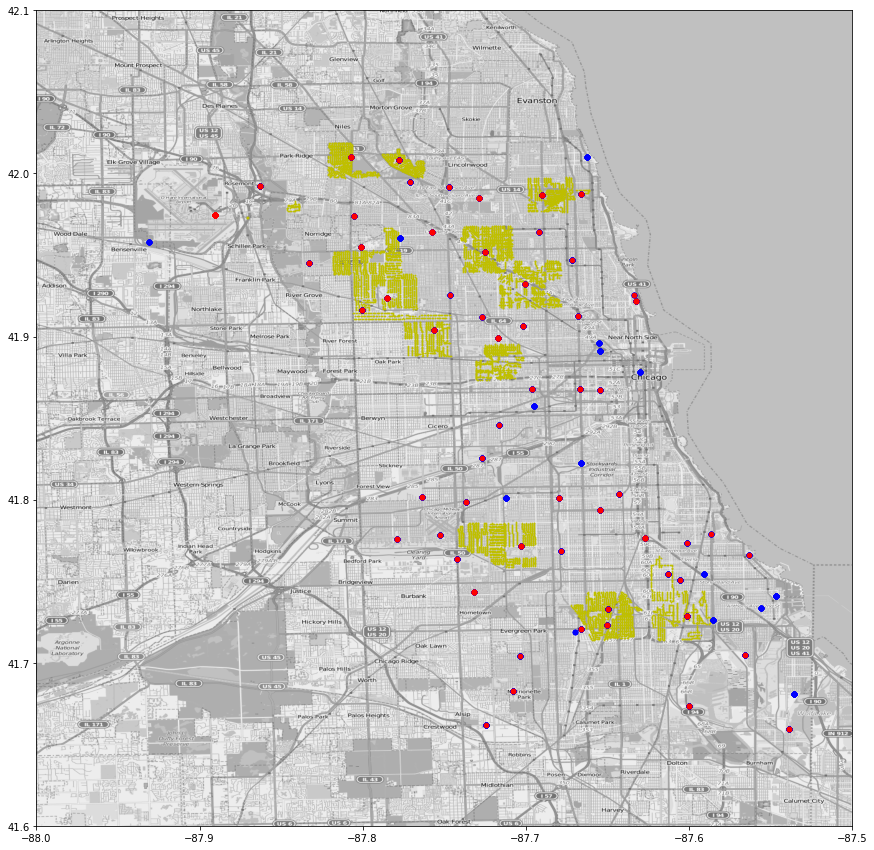

In [35]:
# generate plot
plt.figure(figsize=(20,15))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
plt.scatter(x=longs_spray_2013, y=lats_spray_2013, c='y', s=0.5)
plt.scatter(x=longs_train_2013_0, y=lats_train_2013_0, c='b', s=20)
plt.scatter(x=longs_train_2013_1, y=lats_train_2013_1, c='r', s=20)

#plt.show()
plt.savefig('map.png')

## Train map 2007 / 2009 

In [36]:
train_2007 = train['2007']

In [37]:
lats_train_2007_0 = train_2007[train_2007['WnvPresent']==0].Latitude
longs_train_2007_0 = train_2007[train_2007['WnvPresent']==0].Longitude

In [38]:
lats_train_2007_1 = train_2007[train_2007['WnvPresent']==1].Latitude
longs_train_2007_1 = train_2007[train_2007['WnvPresent']==1].Longitude

In [39]:
train_2009 = train['2009']

In [40]:
lats_train_2009_0 = train_2009[train_2009['WnvPresent']==0].Latitude
longs_train_2009_0 = train_2009[train_2009['WnvPresent']==0].Longitude

In [41]:
lats_train_2009_1 = train_2009[train_2009['WnvPresent']==1].Latitude
longs_train_2009_1 = train_2009[train_2009['WnvPresent']==1].Longitude

# Pièce De Résistance
- 2011 spray in green
- 2013 spray in yellow
- train 2007 - 2013 in decreasing sizes
- red: positive
- white: negative

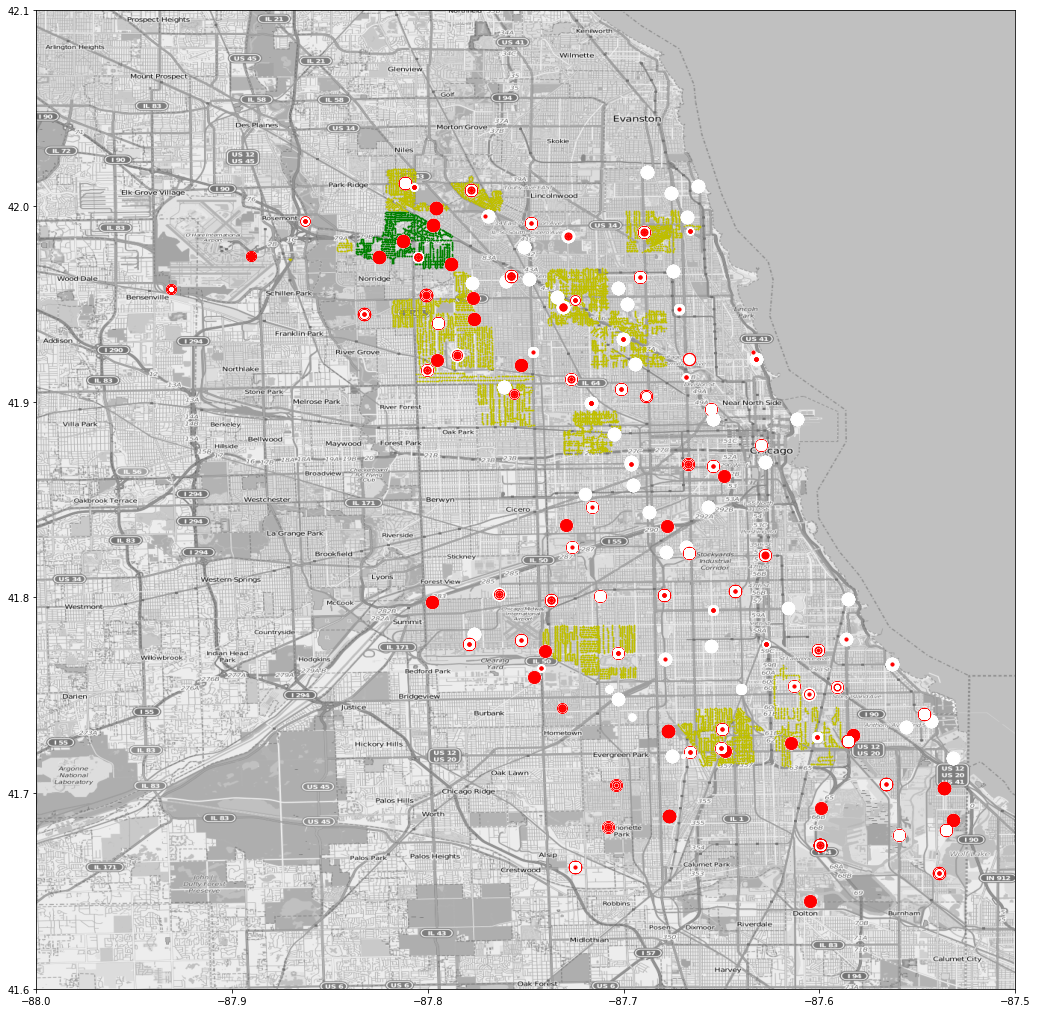

In [43]:
# generate plot
plt.figure(figsize=(24,18))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
plt.scatter(x=longs_spray_2011, y=lats_spray_2011, c='g', s=0.5)
plt.scatter(x=longs_spray_2013, y=lats_spray_2013, c='y', s=0.5)
plt.scatter(x=longs_train_2007_0, y=lats_train_2007_0, c='w', s=150)
plt.scatter(x=longs_train_2007_1, y=lats_train_2007_1, c='r', s=150)
plt.scatter(x=longs_train_2009_0, y=lats_train_2009_0, c='w', s=100)
plt.scatter(x=longs_train_2009_1, y=lats_train_2009_1, c='r', s=100)
plt.scatter(x=longs_train_2011_0, y=lats_train_2011_0, c='w', s=50)
plt.scatter(x=longs_train_2011_1, y=lats_train_2011_1, c='r', s=50)
plt.scatter(x=longs_train_2013_0, y=lats_train_2013_0, c='w', s=10)
plt.scatter(x=longs_train_2013_1, y=lats_train_2013_1, c='r', s=10)